# 05 - Results

In [16]:
import xarray as xr
import matplotlib.pyplot as plt
import geopandas as gpd
from sklearn.metrics import silhouette_score
import numpy as np

from models.X_RCC import XRCC, XRCC_silhouette
from visualization.custom_plots import standard_format, day_of_year_to_date, standard_format_single, plot_seasons_bk_results

import warnings
warnings.filterwarnings('ignore')

In [17]:
# -- FREE PARAMETERS
n_seasons   = 2
n_iters     = 200

In [18]:
# Geopackages with boundaries
country_boundary_file   = '../data/raw/external/GADM41_IND.gpkg' 
world_boundary_file     = '../data/raw/external/GADM41_WORLD.gpkg' 

# Path for results
clustering_results_path  = f'../data/results/netcdf_files/clustering_results_{n_seasons}seas_{n_iters}iters.nc'
literature_results_path  = f'../data/preprocessed/external/monsoon_dates.nc'

results_path_image  = f'../data/results/images/bias_results_{n_iters}iters.png'

# Geodataframes for boudaries - Level 0 is for country boundaries 
country_boundary    = gpd.read_file(country_boundary_file, layer = 'ADM_ADM_1')
world_boundary      = gpd.read_file(world_boundary_file, layer = 'ADM_0')

In [19]:
clustering_results = xr.open_dataset(clustering_results_path)
literature_results = xr.open_dataset(literature_results_path)

In [20]:
a = clustering_results.sel(cluster=0).__xarray_dataarray_variable__
b = literature_results.sel(cluster=0).date

onset_diff = (b-a).rename('Bias').drop(['spatial_ref']).assign_coords(season_idx='onset')

a = clustering_results.sel(cluster=1).__xarray_dataarray_variable__
b = literature_results.sel(cluster=1).date

withdrawal_diff = (b-a).rename('Bias').drop(['spatial_ref']).assign_coords(season_idx='withdrawal')

tota = xr.concat([onset_diff,withdrawal_diff], dim='season_idx')

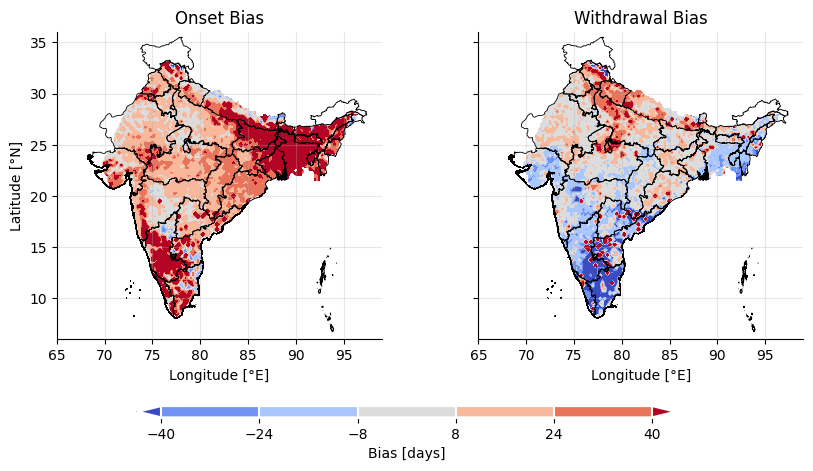

In [22]:
plot = tota.plot.contourf(col='season_idx', col_wrap=2, vmin=-40, vmax=40, levels=6, add_colorbar=False, figsize=(9,4), cmap='coolwarm')

standard_format( plot,
                 country_boundary   = country_boundary,
                 # world_boundary     = world_boundary,
                 custom_cbar        = True
                )

#plot.cbar.set_ticks(ticks = np.linspace(-30,30,5), labels = np.linspace(-30,30,5))

plot.axes[0][0].set_title('Onset Bias', size=12)
plot.axes[0][1].set_title('Withdrawal Bias', size=12)
plot.cbar.set_label('Bias [days]')


plt.savefig(results_path_image, dpi=300, bbox_inches='tight', transparent=False)